In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
import statsmodels.api as sm
from colorama import Fore, Style
from scipy.optimize import fsolve, curve_fit
import yfinance as yf
import akshare as ak
import sys
sys.path.append('../src') 
from utils import plot_candlestick

In [2]:
def get_optimum_clusters(
    df: pd.DataFrame,
    saturation_point):
    '''
    param df: dataframe
    param saturation_point: The amount of difference we are willing to detect
    return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''
    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]
    return optimum_clusters

def support_and_resistance(df, saturation_point: float=0.05):
    '''
    Calculate support and resistance using KMean
    '''
    df_plot = df
    # low_clusters = get_optimum_clusters(df_plot[(df_plot['low']!=df_plot['open'])&(df_plot['low']!=df_plot['close'])][['date',"low"]].set_index('date'), saturation_point)
    low_clusters = get_optimum_clusters(df_plot[['date',"low"]].set_index('date'), saturation_point)
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    # high_clusters = get_optimum_clusters(df_plot[(df_plot['high']!=df_plot['open'])&(df_plot['high']!=df_plot['close'])][['date',"high"]].set_index('date'), saturation_point)
    high_clusters = get_optimum_clusters(df_plot[['date',"high"]].set_index('date'), saturation_point)
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    return low_centers, high_centers

In [3]:
# Tongxin ETF
etf_code = "sh515880"  # ETF代码
start_date = "20220101"  # 开始日期
end_date = "20250508"  # 结束日期

# 调用 AKShare 的 fund_etf_hist_sina 接口获取数据
etf_hist = ak.fund_etf_hist_sina(symbol=etf_code)

etf_hist.tail()

,date,open,high,low,close,volume
1370,2025-05-09,1.241,1.244,1.224,1.236,175701300
1371,2025-05-12,1.257,1.266,1.247,1.265,262483500
1372,2025-05-13,1.284,1.285,1.256,1.257,340993440
1373,2025-05-14,1.262,1.286,1.261,1.266,173088400
1374,2025-05-15,1.264,1.265,1.230,1.232,127311050


[[0.89904762]
 [0.98907018]
 [1.03866667]
 [1.10369072]
 [1.16458333]
 [1.25155172]
 [1.33046429]
 [1.39683333]] [[0.93728571]
 [1.01532143]
 [1.06791045]
 [1.13606667]
 [1.2005    ]
 [1.28956364]
 [1.3666    ]
 [1.44074468]]


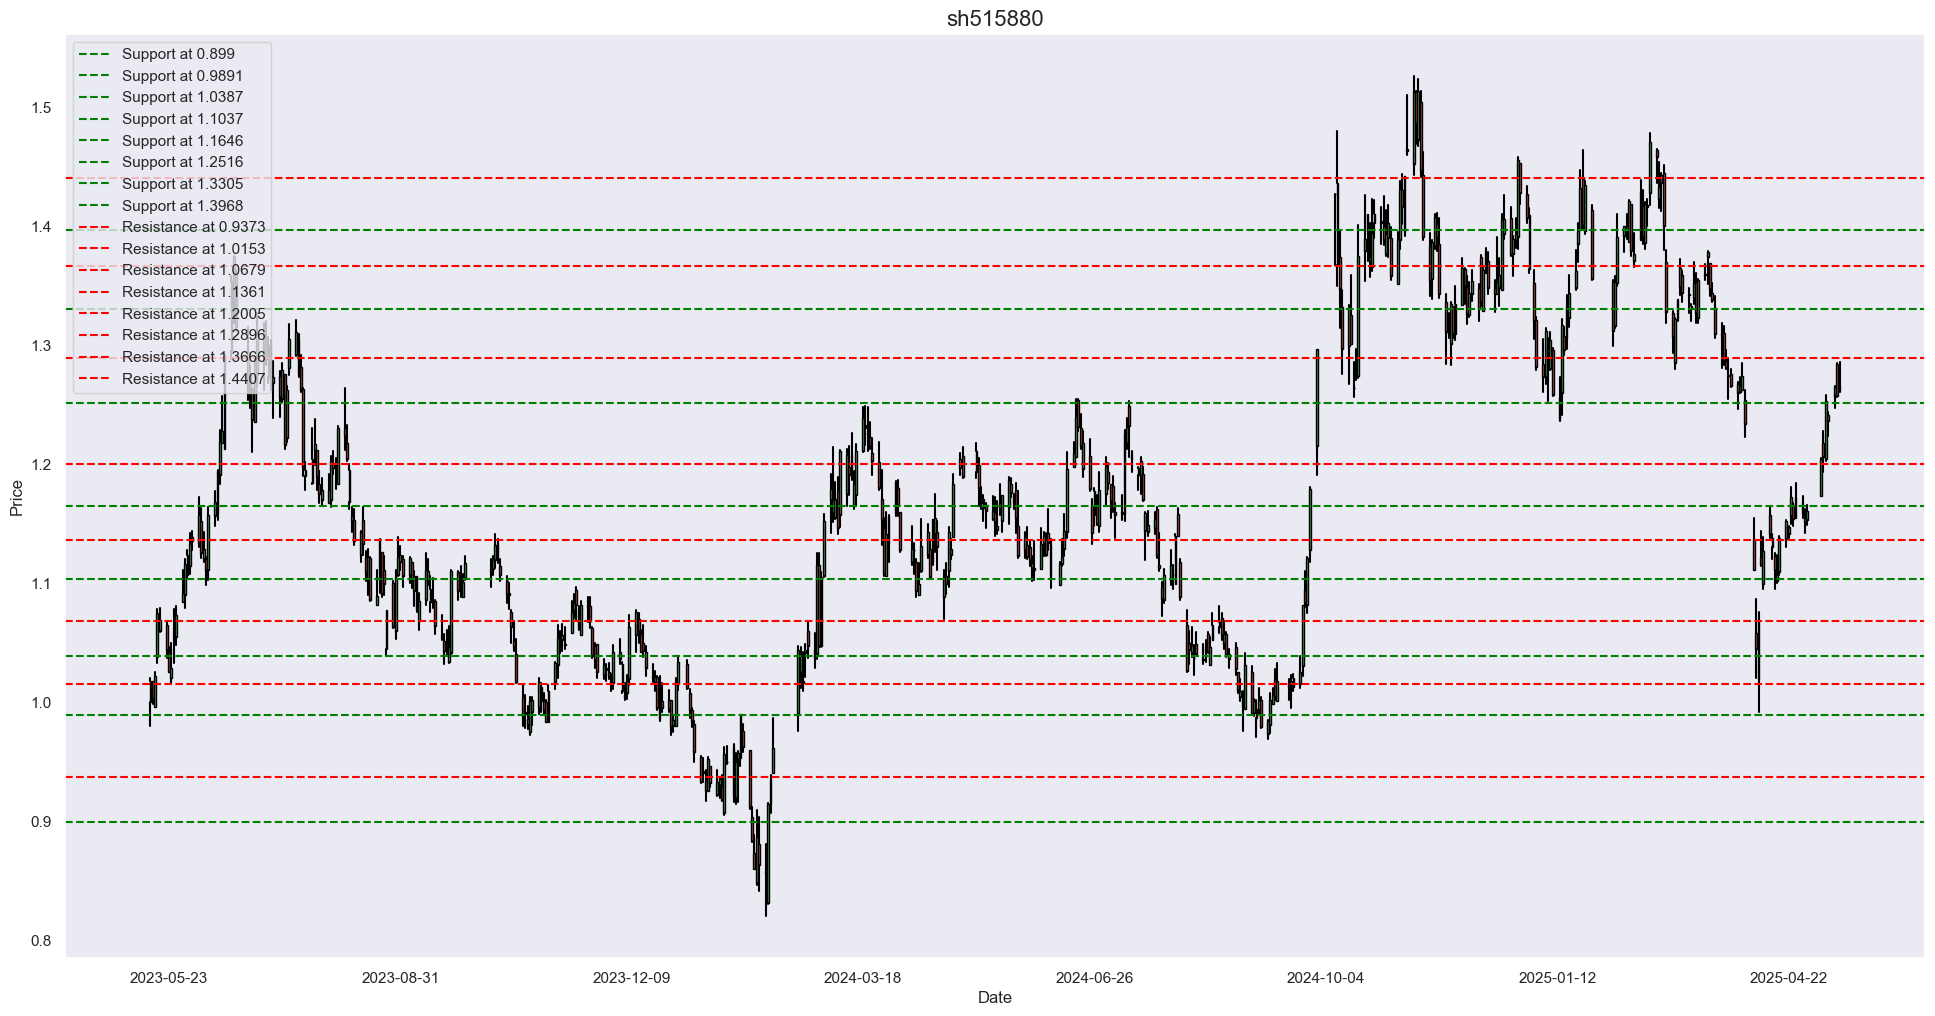

In [4]:
start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d')
etf_hist['date'] = pd.to_datetime(etf_hist['date'])
df_plot = etf_hist[etf_hist['date'].between(start,datetime.today().strftime('%Y-%m-%d'))]
ax = plot_candlestick(df_plot, figsize=(24,12))
low_centers, high_centers = support_and_resistance(df_plot)
print(low_centers, high_centers)
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--', label=f'Support at {round(low[0],4)}')
for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--', label=f'Resistance at {round(high[0],4)}')
ax.set_title("sh515880", fontsize=16)
ax.legend(loc='upper left')

In [5]:
etf_code = "sh513180"  # ETF代码
start_date = "20220101"  # 开始日期
end_date = "20221231"  # 结束日期

etf_hist = ak.fund_etf_hist_sina(symbol=etf_code)
etf_hist.tail()

,date,open,high,low,close,volume
957,2025-05-08,0.712,0.726,0.711,0.718,7006099600
958,2025-05-09,0.717,0.718,0.705,0.708,6466830285
959,2025-05-12,0.725,0.727,0.715,0.726,8492655835
960,2025-05-13,0.736,0.736,0.718,0.720,7409757300
961,2025-05-14,0.727,0.735,0.724,0.732,8163305909


In [6]:
etf_spot = ak.fund_etf_spot_em()
# 筛选出通信ETF（sh515880）的数据
etf_data = etf_spot[etf_spot["代码"] == "515880"]
etf_data

,代码,名称,最新价,IOPV实时估值,基金折价率,涨跌额,涨跌幅,成交量,成交额,开盘价,...,小单净流入-净额,小单净流入-净占比,现手,买一,卖一,最新份额,流通市值,总市值,数据日期,更新时间


In [7]:
fund_etf_category_sina_df = ak.fund_etf_category_sina()
fund_etf_category_sina_df.head()

,代码,名称,最新价,涨跌额,涨跌幅,买入,卖出,昨收,今开,最高,最低,成交量,成交额
0,sz169201,浙商鼎盈LOF,1.468,-0.020,-1.344,1.448,1.468,1.488,1.468,1.468,1.468,100,147
1,sz169106,东方红创优定开,1.064,-0.002,-0.188,1.064,1.068,1.066,1.064,1.064,1.064,20000,21280
2,sz169105,东方红睿华LOF,1.291,-0.009,-0.692,1.291,1.299,1.300,1.300,1.300,1.291,6000,7755
3,sz169104,东方红睿满LOF,1.495,-0.020,-1.320,1.495,1.505,1.515,1.492,1.504,1.490,5933,8848
4,sz169103,东方红睿轩定开,1.819,0.000,0.000,1.804,1.818,1.819,1.820,1.820,1.819,3000,5458


In [8]:
fund_etf_category_sina_df[fund_etf_category_sina_df["代码"] == "sh513180"]

,代码,名称,最新价,涨跌额,涨跌幅,买入,卖出,昨收,今开,最高,最低,成交量,成交额


In [9]:
fund_etf_category_sina_df[fund_etf_category_sina_df["代码"].str[0:2] == "sh"]

,代码,名称,最新价,涨跌额,涨跌幅,买入,卖出,昨收,今开,最高,最低,成交量,成交额
271,sh506008,科创板长城,0.740,-0.003,-0.404,0.739,0.740,0.743,0.743,0.743,0.739,56600,41892
272,sh506006,汇添富科创板,0.816,-0.007,-0.851,0.815,0.816,0.823,0.823,0.823,0.816,53000,43358
273,sh506005,科创板博时,0.829,-0.007,-0.837,0.828,0.829,0.836,0.834,0.834,0.829,1068988,887915
274,sh506003,富国科创板,0.687,-0.007,-1.009,0.687,0.692,0.694,0.693,0.694,0.687,504035,346720
275,sh506002,易方达科创板,0.909,-0.009,-0.980,0.909,0.910,0.918,0.925,0.925,0.908,76300,69486
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,sh501009,生物科技LOF,1.142,0.000,0.000,1.140,1.142,1.142,1.115,1.143,1.115,176565,201076
380,sh501008,互联网医疗LOFC,0.910,-0.018,-1.940,0.908,0.912,0.928,0.928,0.928,0.910,10200,9341
381,sh501007,互联网医疗LOF,0.940,-0.010,-1.053,0.935,0.944,0.950,0.940,0.940,0.934,18600,17401
382,sh501005,精准医疗LOF,0.841,-0.003,-0.355,0.838,0.841,0.844,0.839,0.844,0.838,87300,73270


In [4]:
spot_hist_sge_df = ak.spot_hist_sge(symbol='Au99.99')
spot_hist_sge_df['date']= pd.to_datetime(spot_hist_sge_df['date'])
spot_hist_sge_df.head()

,date,open,close,low,high
0,2016-12-19,262.45,262.76,262.02,263.50
1,2016-12-20,262.88,262.06,261.42,263.70
2,2016-12-21,262.40,260.97,258.60,262.65
3,2016-12-22,261.18,260.00,259.05,261.18
4,2016-12-23,258.95,260.07,258.70,260.37


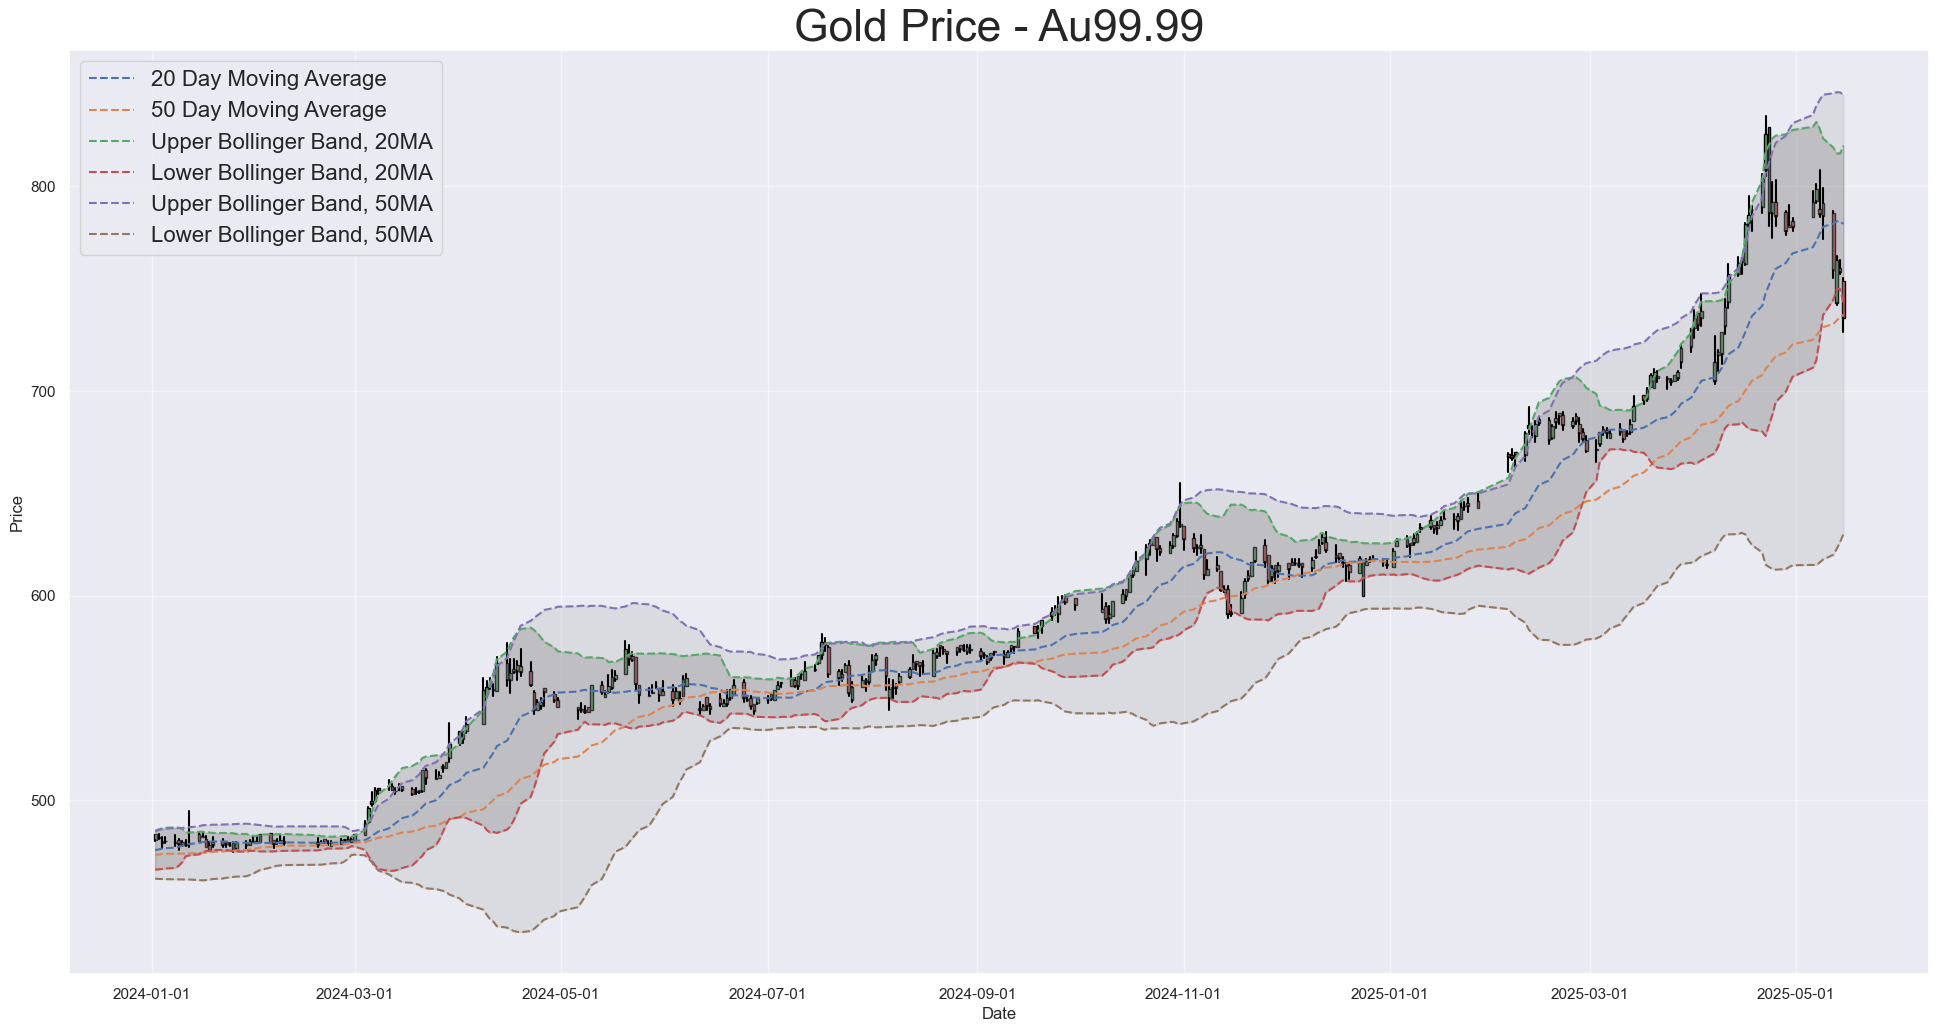

In [5]:
spot_hist_sge_df['20 Day MA'] = spot_hist_sge_df['close'].rolling(window=20).mean()
spot_hist_sge_df['20 Day STD'] = spot_hist_sge_df['close'].rolling(window=20).std()
spot_hist_sge_df['50 Day MA'] = spot_hist_sge_df['close'].rolling(window=50).mean()
spot_hist_sge_df['50 Day STD'] = spot_hist_sge_df['close'].rolling(window=50).std()        
# Calculate upper and lower bands
spot_hist_sge_df['Upper Band - 20MA'] = spot_hist_sge_df['20 Day MA'] + (spot_hist_sge_df['20 Day STD'] * 2)
spot_hist_sge_df['Lower Band - 20MA'] = spot_hist_sge_df['20 Day MA'] - (spot_hist_sge_df['20 Day STD'] * 2)
spot_hist_sge_df['Upper Band - 50MA'] = spot_hist_sge_df['50 Day MA'] + (spot_hist_sge_df['50 Day STD'] * 2.5)
spot_hist_sge_df['Lower Band - 50MA'] = spot_hist_sge_df['50 Day MA'] - (spot_hist_sge_df['50 Day STD'] * 2.5)
spot_hist_sge_df['120 Day MA'] = spot_hist_sge_df['close'].rolling(window=120).mean()
spot_hist_sge_df['200 Day MA'] = spot_hist_sge_df['close'].rolling(window=200).mean()

df = spot_hist_sge_df[spot_hist_sge_df['date']>='2024-01-01']

ax = plot_candlestick(df, figsize=(24,12))
ax.grid(True, alpha=0.5)
ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
ax.plot(df['date'], df['50 Day MA'], ls='--', label='50 Day Moving Average')

ax.plot(df['date'], df['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
ax.plot(df['date'], df['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
ax.fill_between(df['date'], df['Upper Band - 20MA'], df['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
ax.plot(df['date'], df['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
ax.plot(df['date'], df['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
ax.fill_between(df['date'], df['Upper Band - 50MA'], df['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

ax.set_title('Gold Price - Au99.99', fontsize=32)
ax.legend(fontsize=16)

[[478.71780488]
 [506.41222222]
 [547.65796875]
 [564.8378    ]
 [592.17      ]
 [614.02477273]
 [631.41809524]
 [677.027     ]
 [716.12105263]
 [775.93578947]] [[482.11525   ]
 [509.145     ]
 [553.73380952]
 [572.54254545]
 [610.69565217]
 [632.59205128]
 [682.72555556]
 [712.38866667]
 [754.759     ]
 [799.988125  ]]


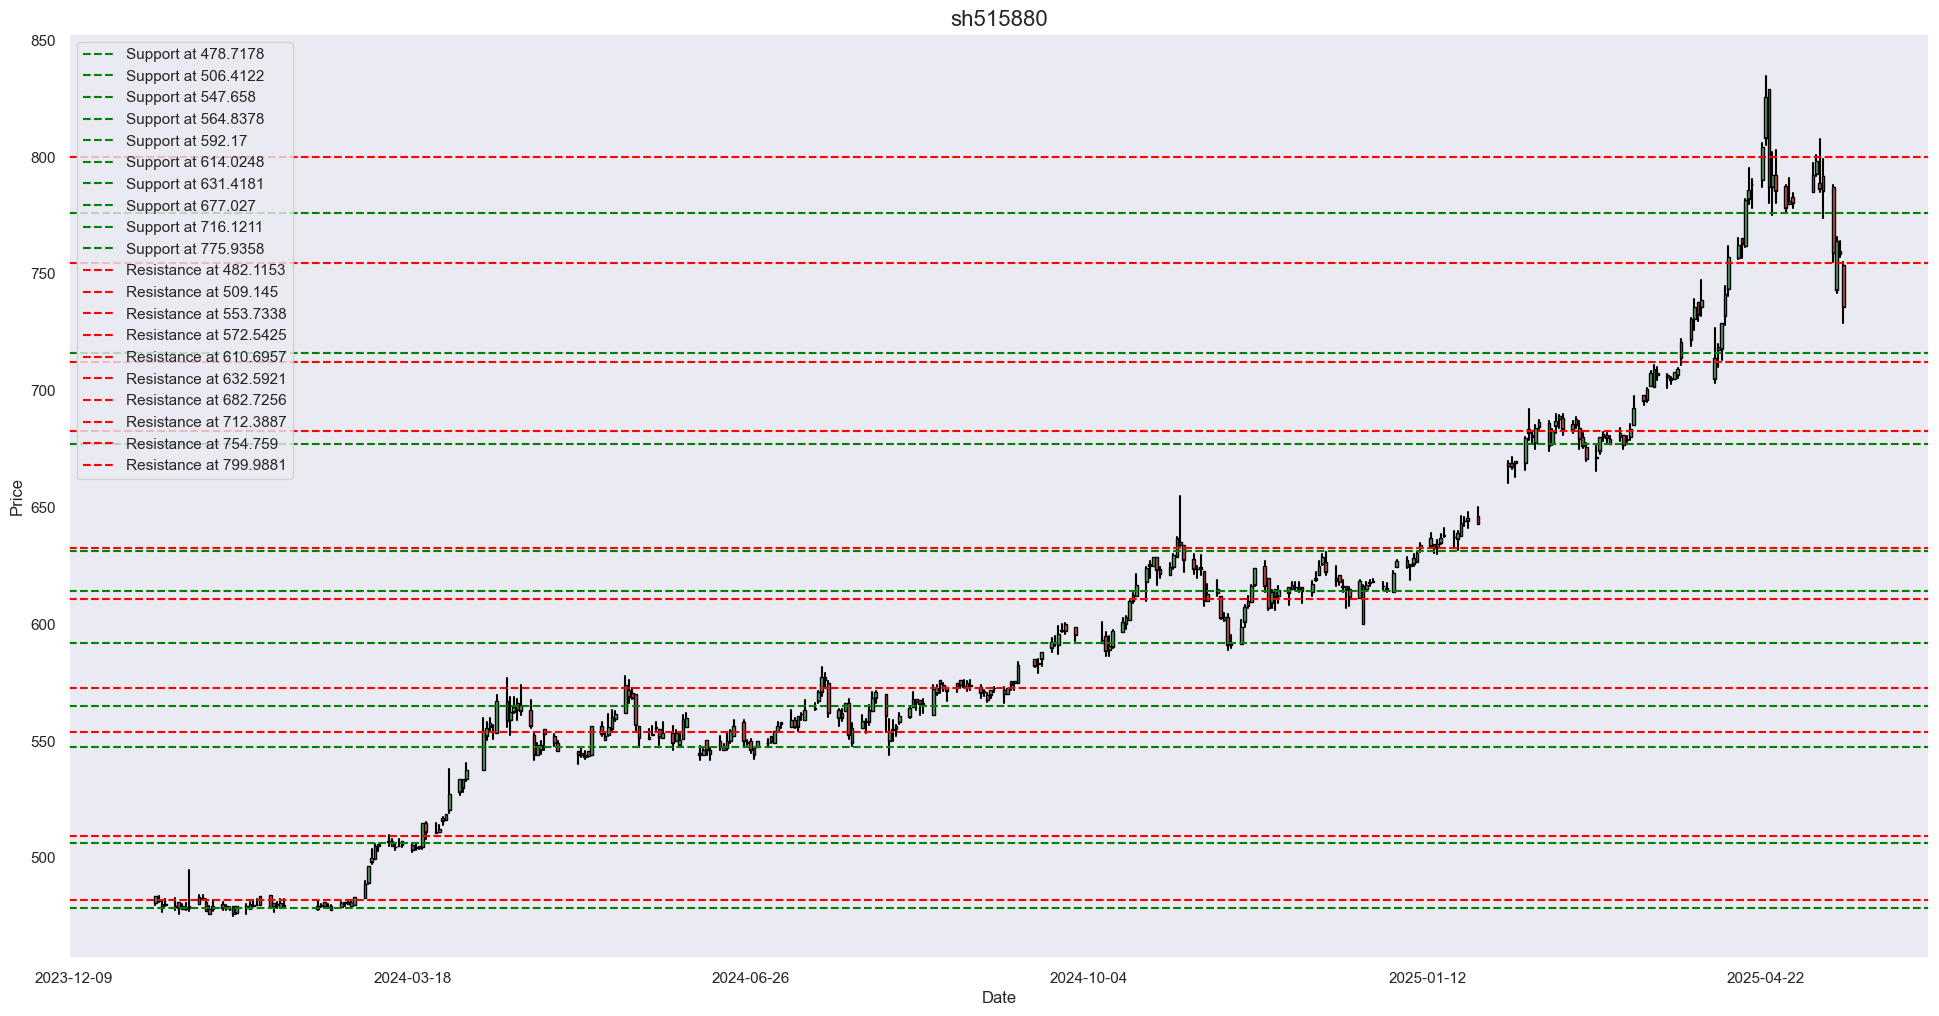

In [6]:
df_plot = spot_hist_sge_df[spot_hist_sge_df['date'].between('2024-01-01',datetime.today().strftime('%Y-%m-%d'))]
ax = plot_candlestick(df_plot, figsize=(24,12))
low_centers, high_centers = support_and_resistance(df_plot)
print(low_centers, high_centers)
for low in low_centers[:]:
    ax.axhline(low[0], color='green', ls='--', label=f'Support at {round(low[0],4)}')
for high in high_centers[:]:
    ax.axhline(high[0], color='red', ls='--', label=f'Resistance at {round(high[0],4)}')
ax.set_title("sh515880", fontsize=16)
ax.legend(loc='upper left')

In [11]:
spot_hist_sge_df.tail(50)

,date,open,close,low,high,20 Day MA,20 Day STD,50 Day MA,50 Day STD,Upper Band - 20MA,Lower Band - 20MA,Upper Band - 50MA,Lower Band - 50MA,120 Day MA,200 Day MA
1987,2025-03-03,671.00,671.78,665.50,676.28,677.4485,10.559875,646.9802,27.136087,698.568249,656.328751,714.820417,579.139983,621.620083,596.33105
1988,2025-03-04,674.00,679.97,673.00,679.99,679.2920,6.795032,648.1310,27.293339,692.882064,665.701936,716.364347,579.897653,622.508750,597.00670
1989,2025-03-05,680.00,681.57,678.30,682.47,679.9770,6.251818,649.3956,27.349623,692.480637,667.473363,717.769658,581.021542,623.397667,597.69365
1990,2025-03-06,681.00,679.70,677.00,681.80,680.5930,5.507997,650.6254,27.301150,691.608994,669.577006,718.878276,582.372524,624.283167,598.37500
1991,2025-03-07,677.00,679.48,677.00,680.70,681.1175,4.798738,651.8850,27.146993,690.714975,671.520025,719.752483,584.017517,625.189667,598.99070
1992,2025-03-10,680.00,681.99,678.50,684.00,681.2345,4.789592,653.2342,26.928060,690.813685,671.655315,720.554351,585.914049,626.110583,599.63560
1993,2025-03-11,680.90,676.71,675.00,680.90,680.8940,4.860109,654.5318,26.451156,690.614217,671.173783,720.659689,588.403911,627.020417,600.26585
1994,2025-03-12,679.00,679.43,678.00,680.40,680.8550,4.869008,655.7524,26.156296,690.593016,671.116984,721.143139,590.361661,627.917417,600.88305
1995,2025-03-13,680.00,683.77,679.00,685.89,680.8505,4.866125,657.1010,25.818895,690.582750,671.118250,721.648237,592.553763,628.841833,601.50015
1996,2025-03-14,685.50,692.67,685.50,697.79,681.1550,5.404303,658.6184,25.630820,691.963606,670.346394,722.695451,594.541349,629.861917,602.15630


In [8]:
last_49day_price = spot_hist_sge_df['close'][-50:-1]
p_ma = np.mean(last_49day_price)
print('50MA break point:', round(p_ma,2))

50MA break point: 737.37
